In [1]:
import torch
import random
import numpy as np
import argparse

import torch
from torch import Tensor
from torch_geometric.logging import init_wandb, log
from torch_geometric.datasets import Planetoid
from utils import train, test, non_smooth_label_metric, label_difference, edgeindex2adj
from models import GCN, GAT, LP
import torch.nn.functional as F
import multiprocessing as mp


In [2]:
citeseer = Planetoid(root='.', name='Citeseer')
cora = Planetoid(root='.', name='Cora')
pubmed = Planetoid(root='.', name='Pubmed')
torch.use_deterministic_algorithms(True)

In [3]:
k = 5
seeds = [1234, 42, 2021]
seeds = [1234]
lr = 0.02
epochs = 200

In [4]:
# dataset = citeseer
# model = GCN(dataset.num_features, 16, dataset.num_classes)

# dataset = cora
# model = GCN(dataset.num_features, 16, dataset.num_classes)

# dataset = pubmed
# model = GCN(dataset.num_features, 16, dataset.num_classes)

# dataset = citeseer
# model = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)

dataset = cora
model = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)

# dataset = pubmed
# model = GAT(dataset.num_features, 8, dataset.num_classes, heads=8)

In [5]:
torch.manual_seed(0)
data = dataset[0]
for c in data.y.unique():
    idx = ((data.y == c) & data.train_mask).nonzero(as_tuple=False).view(-1)
    idx = idx[torch.randperm(idx.size(0))]
    idx = idx[k:]
    data.train_mask[idx] = False

In [6]:
from models import AdaptiveLP
lp = AdaptiveLP(num_layers=8, yshape=dataset[0].y.shape[0], edge_dim=dataset.edge_index.shape[1])

In [7]:
av_val_acc = av_test_acc = 0
state_dict_model = model.state_dict().copy()
state_dict_lp = lp.state_dict().copy()
seeds = [1234]
for seed in seeds:
    print("RUNNING FOR SEED =", seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    model.load_state_dict(state_dict_model)
    lp.load_state_dict(state_dict_lp)
    
    optimizer = torch.optim.Adam(list(model.parameters()) + list(lp.parameters()), lr=lr, weight_decay=5e-4)

    best_val_acc = final_test_acc = 0
    for epoch in range(1, 200):
        model.train()
        lp.train()
        optimizer.zero_grad()
        
        out_lp = lp(data)
        out_model = model(data.x, data.edge_index, lp.edge_weight.sigmoid())

        
        loss_model = F.cross_entropy(out_model[data.train_mask], data.y[data.train_mask])
        # loss_lp = (out_lp[data.train_mask] - data.y[data.train_mask]).pow(2).mean()
        loss_lp = F.cross_entropy(out_lp[data.train_mask], data.y[data.train_mask])
        ##########################################
        # sample some nodes from the unlabelled set
        unlab_mask = ~data.train_mask & ~data.val_mask & ~data.test_mask
        unlab_idx = unlab_mask.nonzero(as_tuple=False).view(-1)
        sample_unlab_idx = unlab_idx[torch.rand(unlab_idx.shape[0]) < 0.005]
        sample_unlab_mask = torch.zeros(unlab_mask.shape[0], dtype=torch.bool)
        sample_unlab_mask[sample_unlab_idx] = True
        
        # loss_unsup = F.cross_entropy(out_model[sample_unlab_mask], out_lp[sample_unlab_mask].argmax(dim=1))
        loss_unsup = F.cross_entropy(out_lp[sample_unlab_mask], out_model[sample_unlab_mask].argmax(dim=1))
        ##########################################
        # print(loss_model, loss_lp, loss_unsup)
        loss = loss_model + 2 * loss_lp + loss_unsup
        loss.backward()
        optimizer.step()
        
        train_acc, val_acc, tmp_test_acc = test(model, data)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        if epoch % 25 == 0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-2)
    for epoch in range(1, 200):
        loss = train(model, data, optimizer, loss='cross_entropy')
        train_acc, val_acc, tmp_test_acc = test(model, data)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        if epoch % 25 == 0:
            log(Epoch=epoch, Loss=loss, Train=train_acc, Val=val_acc, Test=test_acc)
    
    print(f'Best Val Acc: {best_val_acc:.4f}', f'Test Acc: {test_acc:.4f}')
    av_val_acc += best_val_acc
    av_test_acc += test_acc
    
print(f'Average Val Acc / Average Test Acc: {av_val_acc / len(seeds):.4f} / {av_test_acc / len(seeds):.4f}')

RUNNING FOR SEED = 1234
Epoch: 025, Loss: 5.708117485046387, Train: 1.0000, Val: 0.6300, Test: 0.6730
Epoch: 050, Loss: 5.756698131561279, Train: 1.0000, Val: 0.6780, Test: 0.6860
Epoch: 075, Loss: 5.198805809020996, Train: 1.0000, Val: 0.6580, Test: 0.6860
Epoch: 100, Loss: 5.327582359313965, Train: 1.0000, Val: 0.6620, Test: 0.6860
Epoch: 125, Loss: 4.793585777282715, Train: 1.0000, Val: 0.6560, Test: 0.6860
Epoch: 150, Loss: 4.839672565460205, Train: 1.0000, Val: 0.6100, Test: 0.7020
Epoch: 175, Loss: 4.9784064292907715, Train: 1.0000, Val: 0.6920, Test: 0.7020
Epoch: 025, Loss: 0.8326388001441956, Train: 1.0000, Val: 0.6600, Test: 0.7010
Epoch: 050, Loss: 0.7093577980995178, Train: 1.0000, Val: 0.6700, Test: 0.7010
Epoch: 075, Loss: 0.9833714365959167, Train: 1.0000, Val: 0.7120, Test: 0.7300
Epoch: 100, Loss: 0.892390787601471, Train: 1.0000, Val: 0.7360, Test: 0.7460
Epoch: 125, Loss: 0.5773319005966187, Train: 1.0000, Val: 0.6820, Test: 0.7460
Epoch: 150, Loss: 0.879718780517578

In [20]:
weights = lp.edge_weight

In [9]:

import networkx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(2)
features = model.features.detach().numpy()
# features = dataset[0].x
features_embedded = tsne.fit_transform(features)
features_embedded.shape

C:\Users\kousi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kousi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(2708, 2)

In [10]:
import networkx as nx

In [12]:
weights.shape

torch.Size([10556])

In [21]:
weights = (weights - weights.min())/(weights.max() - weights.min())

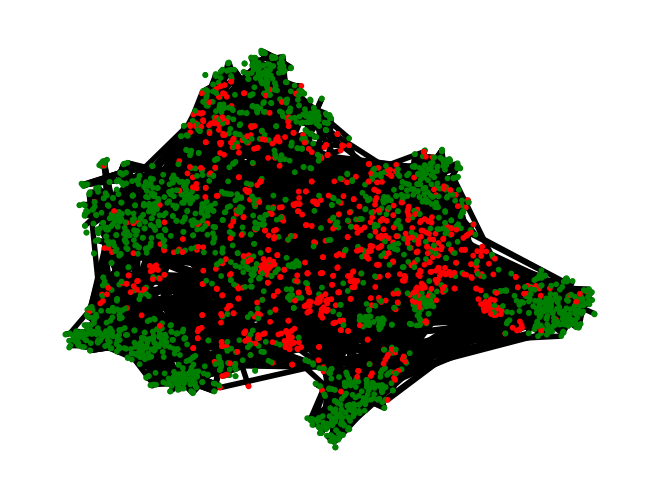

In [22]:
data = dataset[0]
preds = model(data.x, data.edge_index, weights.sigmoid()).argmax(dim=1)
num_sample_nodes = 100
sample_nodes = random.sample(range(data.num_nodes), num_sample_nodes)
weights = weights.detach().numpy()

G = nx.Graph()

G.add_nodes_from(range(data.num_nodes))

edge_index = data.edge_index.t().tolist()

G.add_edges_from(edge_index)
new_G = G.subgraph(sample_nodes)

color_map = ["red", "green"]
node_color = [color_map[int(data.y[label]==preds[label])] for label in range(data.num_nodes)]

pos = {}
for i, node in enumerate(G.nodes()):
    pos[node] = features_embedded[i]

# Draw graph with node color and smaller size

nx.draw(G, pos = pos, node_color=node_color, node_size = 10, width=weights, edge_color="black")


plt.show()

In [15]:
weights

Parameter containing:
tensor([-6.4098e-02,  1.2359e-01,  1.8512e-01,  ...,  3.8450e-03,
         6.5189e-04, -1.8219e-05], requires_grad=True)